<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_catalogues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install library for accessing numerous astronomical datasets

In [1]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 15.4 MB/s eta 0:00:00


In [2]:
from astroquery.sdss import SDSS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# an SQL query for SDSS data
query = """
SELECT TOP 10000
       p.ra, p.dec,
       p.u, p.g, p.r, p.i, p.z,
       s.z as redshift,
       s.class as specClass
FROM SpecObjAll s
JOIN PhotoObjAll p ON s.bestObjID = p.objid
WHERE s.class in ('STAR', 'GALAXY', 'QSO')
  AND p.clean = 1
  AND p.u between 0 AND 30  -- Exclude obviously invalid magnitudes
  AND p.g between 0 AND 30
  AND p.r between 0 AND 30
  AND p.i between 0 AND 30
  AND p.z between 0 AND 30
ORDER BY NEWID()  -- Randomize the sample
"""

In [4]:
res = SDSS.query_sql(query) # sometimes this produces an error message - try re-running it OR skip to the next cells

In [5]:
df_sdss = res.to_pandas()
df_sdss.head()

,ra,dec,u,g,r,i,z,redshift,specClass
0,217.459531,54.146756,20.55038,20.43209,20.32052,20.35403,20.21797,2.066889,QSO
1,232.891456,48.911527,16.82039,15.37951,14.92678,14.77884,14.71533,-0.000151,STAR
2,201.072229,40.209691,21.67793,20.64783,20.33412,21.20059,20.23664,-0.000598,STAR
3,215.113827,56.166585,16.24425,15.39455,15.12174,15.02557,14.99849,-0.000304,STAR
4,27.745669,-2.360273,18.82811,17.87372,17.54672,17.47410,17.44021,-0.000206,STAR


If there are errors accessing the SDSS data then uncomment the following lines....

In [6]:
#df_sdss = pd.read_csv("https://archive.kasi.re.kr/bigdata/temp/KAML_catalogues.csv", header=0)
#df_sdss.head()

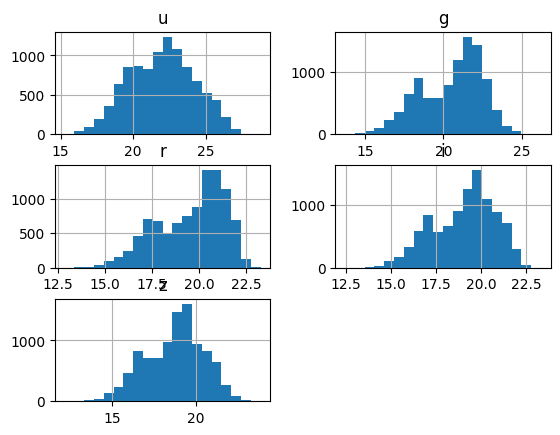

In [7]:
# Plot histogram of the 5 SDSS magnitudes
df_sdss[["u", "g", "r", "i", "z"]].hist(bins=20)
plt.show()

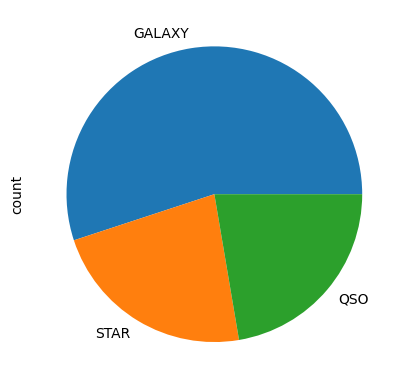

In [8]:
# Plot the distribution of classes
df_sdss["specClass"].value_counts().plot(kind="pie")
plt.show()

In [9]:
# lets make 4 additional pieces of information: color
df_sdss['u_g'] = df_sdss['u'] - df_sdss['g'] # u-g
df_sdss['g_r'] = df_sdss['g'] - df_sdss['r'] # g-r
df_sdss['r_i'] = df_sdss['r'] - df_sdss['i'] # r-i
df_sdss['i_z'] = df_sdss['i'] - df_sdss['z'] # i-z

# View the new color-index columns
df_sdss[['u_g', 'g_r', 'r_i', 'i_z']].head()

,u_g,g_r,r_i,i_z
0,0.11829,0.11157,-0.03351,0.13606
1,1.44088,0.45273,0.14794,0.06351
2,1.03010,0.31371,-0.86647,0.96395
3,0.84970,0.27281,0.09617,0.02708
4,0.95439,0.32700,0.07262,0.03389


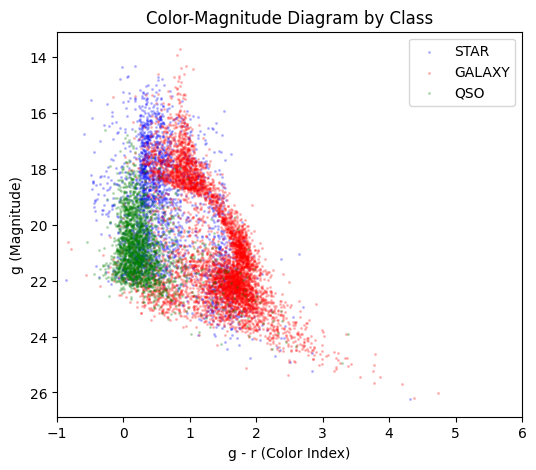

In [10]:
# Plot a color-magnitude diagram
class_colors = {
    'STAR': 'blue',
    'GALAXY': 'red',
    'QSO': 'green'
}

plt.figure(figsize=(6, 5))

for cls, color in class_colors.items():
    subset = df_sdss[df_sdss['specClass'] == cls]
    plt.scatter(subset['g_r'], subset['g'], c=color, label=cls, alpha=0.2, s=1.5)

plt.gca().invert_yaxis()
plt.xlabel('g - r (Color Index)')
plt.ylabel('g (Magnitude)')
plt.title('Color-Magnitude Diagram by Class')
plt.xlim([-1,6])
plt.legend()
plt.show()

The above color-magnitude diagram is not enough to clearly seperate the 3 types of object. So lets try and do some machine learning on this data to help us predict the correct classification

In [12]:
from sklearn.model_selection import train_test_split

features = ["u", "g", "r", "i", "z", "u_g", "g_r", "r_i", "i_z"]  # magnitudes and colors
labels = "specClass"

X = df_sdss[features].values
y = df_sdss[labels].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   # use 20% of the data for testing
                                                    random_state=42,)
                                                    #stratify=y)

print("Training inputs: ",X_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",X_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (8000, 9)
Training outputs:  (8000,)
Testing inputs:  (2000, 9)
Testing outputs:  (2000,)


**Task: Classification**

We want to train a machine to classify the phoometric sources as either Star, Galaxy or QSO

**Decision Tree**

A decision tree is a simple binary classification that aims to maximise the entropy between the seperated objects after each 'decision'

Decisions are binary and hierachical, they can be many levels deep.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(max_depth=2,random_state=42,)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

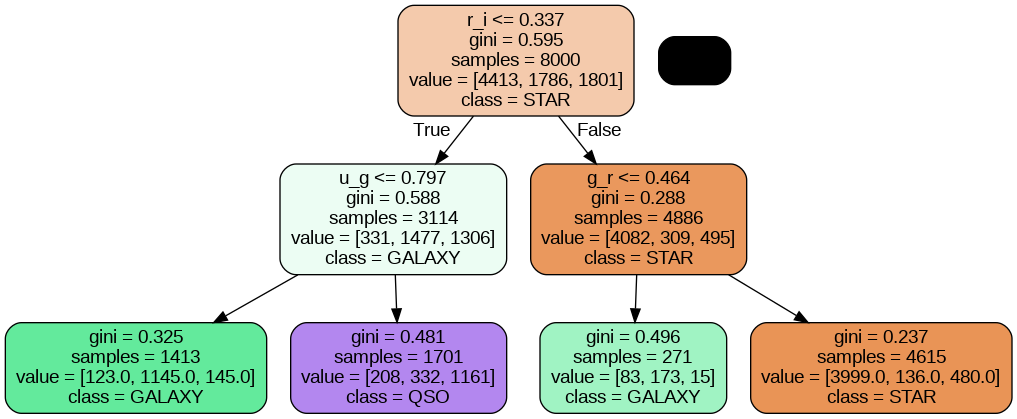

In [14]:
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

#dot_data=export_graphviz(dt)
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=features,
    class_names=["STAR", "GALAXY", "QSO"],
    filled=True,
    rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      GALAXY       0.85      0.90      0.87      1092
         QSO       0.77      0.72      0.75       447
        STAR       0.68      0.63      0.65       461

    accuracy                           0.80      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.79      0.80      0.79      2000



Below are brief definitions of **precision**, **recall**, and **F1**. They provide simple metrics with which to assess the performance of classification methods. We can use these to test hyper-parameters of an alogorithm or compare alogorithms with each other.

---

## Precision
**Precision** is the fraction of predicted positives (i.e., the objects your model labeled as positive) that are actually positive:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$



- **TP** = True Positives: Items correctly labeled as positive.  
- **FP** = False Positives: Items incorrectly labeled as positive.

---

## Recall
**Recall** (or sensitivity) is the fraction of actual positives that are correctly identified:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- **TP** = True Positives.  
- **FN** = False Negatives: Items that were positive but incorrectly labeled as negative.

---

## F1 Score
The **F1 score** is the harmonic mean of precision and recall:

$$
F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

F1 ranges between 0 and 1, with 1 indicating perfect precision and recall.

In [16]:
# This is how you can compute the above metrics...
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='macro')
print('precision:',precision)
recall    = recall_score(y_test, y_pred, average='macro')
print('recall:',recall)
f1    = f1_score(y_test, y_pred, average='macro')
print('f1:',f1)

precision: 0.7662928287557599
recall: 0.7505576842952552
f1: 0.757723197232839


Assignment 1:
* Create a plot of the **precision** as a function of **max depth** of the decision tree. try depths values from 1-20. show precision for test and train samples
* Do the same for **recall**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


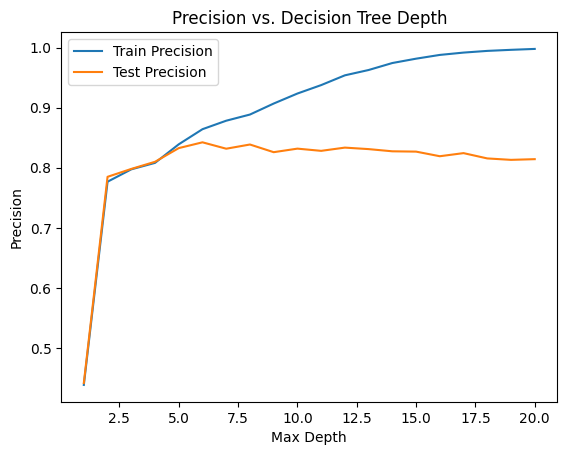

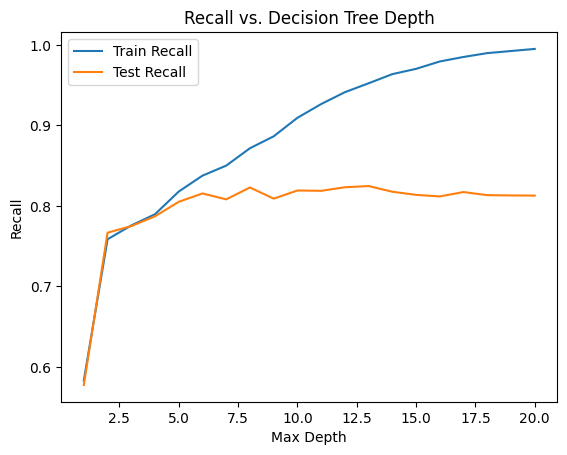

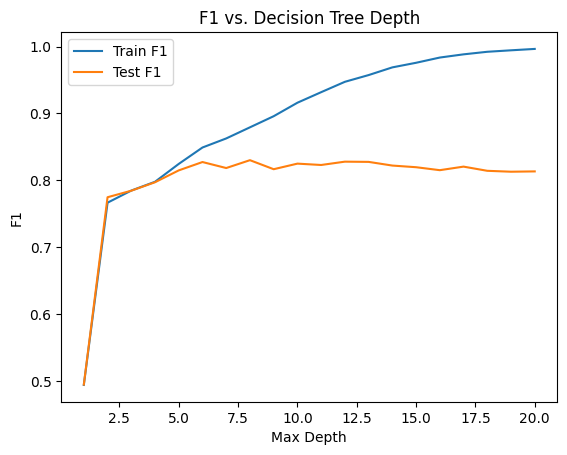

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

max_depths = range(1, 21, 1)  # Decision tree depths to try
train_precision = []
test_precision = []
train_recall = []
test_recall = []
train_f1 = []
test_f1 = []

for d in max_depths:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=42)
    dt.fit(X_train, y_train)

    # Predictions
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)

    # Precision
    train_precision.append(
        precision_score(y_train, y_train_pred, average='macro')  # or 'macro' for multi-class
    )
    test_precision.append(
        precision_score(y_test, y_test_pred, average='macro')
    )

    # Recall
    train_recall.append(
        recall_score(y_train, y_train_pred, average='macro')
    )
    test_recall.append(
        recall_score(y_test, y_test_pred, average='macro')
    )

    # F1
    train_f1.append(
        f1_score(y_train, y_train_pred, average='macro')
    )
    test_f1.append(
        f1_score(y_test, y_test_pred, average='macro')
    )


# --- PLOT PRECISION ---
plt.plot(max_depths, train_precision, label='Train Precision')
plt.plot(max_depths, test_precision, label='Test Precision')
plt.xlabel('Max Depth')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs. Decision Tree Depth')
plt.show()

# --- PLOT RECALL ---
plt.plot(max_depths, train_recall, label='Train Recall')
plt.plot(max_depths, test_recall, label='Test Recall')
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall vs. Decision Tree Depth')
plt.show()

# --- PLOT F1 ---
plt.plot(max_depths, train_f1, label='Train F1')
plt.plot(max_depths, test_f1, label='Test F1')
plt.xlabel('Max Depth')
plt.ylabel('F1')
plt.legend()
plt.title('F1 vs. Decision Tree Depth')
plt.show()


A Random Forest is a machine learning algorithm that belongs to the family of ensemble methods.  It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.  Essentially, it leverages the "wisdom of the crowd" – many relatively weak learners (decision trees) combine to form a powerful predictor.

Here's a breakdown of key aspects:

**1. Decision Trees:**  The foundation of a Random Forest is the decision tree.  Each tree is built on a random subset of the training data (bootstrap aggregating or bagging).  This means that each tree doesn't see the entire dataset, introducing diversity.  Furthermore, at each node of a tree, a random subset of features is considered for the split. This further decorrelates the trees, as they will be based on different features and different subsets of the training data.

**2. Bagging (Bootstrap Aggregating):**  This technique involves creating multiple subsets of the original training data by randomly sampling with replacement.  This means some data points might appear multiple times in a subset, while others might be left out entirely.  Each subset is used to train a different decision tree.  This randomness helps to reduce the variance of the model.

**3. Random Subspace (Feature Randomness):** At each node of each decision tree, the algorithm considers only a random subset of the features when deciding on the best split.  This prevents individual trees from becoming overly dependent on a single feature, increasing the diversity of the forest.

**4. Prediction:** To make a prediction for a new data point, the Random Forest feeds the data point through each decision tree in the forest. Each tree produces a prediction, and the final prediction is an aggregate of the individual tree predictions.  For classification, this is typically the most frequent class (mode); for regression, it's the average of the predictions.


**Advantages of Random Forests:**

* **High accuracy:** Random Forests often achieve high accuracy compared to single decision trees due to the combination of multiple trees and the reduced overfitting.
* **Robustness to outliers:** The use of multiple trees and bootstrapping makes the model less sensitive to outliers in the data.
* **Handles high dimensionality well:** Feature randomness helps the model handle a large number of features efficiently.
* **Can handle missing values:** Random Forests can be adapted to deal with missing data without requiring imputation.
* **Provides feature importance:**  The algorithm can estimate the relative importance of each feature in the prediction, allowing for feature selection and better understanding of the model.

**Disadvantages:**

* **Computational cost:** Training many decision trees can be computationally expensive, especially with large datasets.
* **Black box nature:** While feature importance is available, it can be difficult to interpret the complete decision-making process of a Random Forest.


In the provided code example, a Random Forest isn't directly used. However, the analysis explores decision trees and their performance, illustrating some of the fundamental concepts that apply to Random Forests as well, particularly regarding feature selection, model evaluation (precision, recall, F1-score), and the impact of model parameters (max depth).  You can easily replace the `DecisionTreeClassifier` with `RandomForestClassifier` to apply these same evaluation methods to a Random Forest.



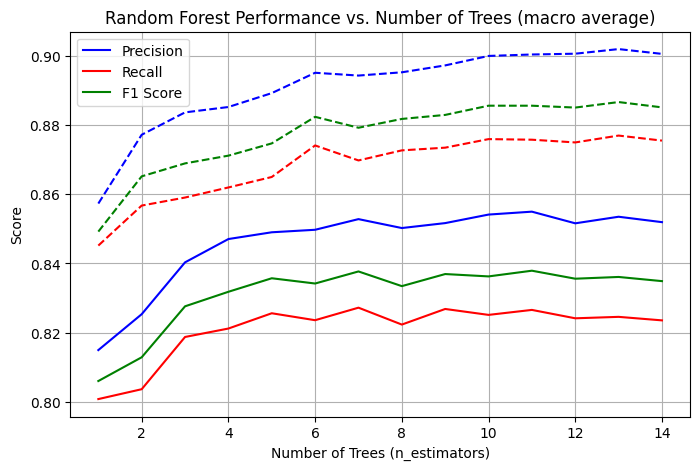

In [ ]:
# Choose a range of tree counts to test
n_estimators_range = range(1, 15, 1)

precisions = []
recalls = []
f1_scores = []
precisions_train = []
recalls_train = []
f1_scores_train = []

# Use 'binary' or 'macro' depending on your task
average_type = 'macro'  # or 'weighted' or 'binary'

for n in n_estimators_range:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=8,
        random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    precisions.append(precision_score(y_test, y_pred, average=average_type))
    recalls.append(recall_score(y_test, y_pred, average=average_type))
    f1_scores.append(f1_score(y_test, y_pred, average=average_type))

    precisions_train.append(precision_score(y_train, y_pred_train, average=average_type))
    recalls_train.append(recall_score(y_train, y_pred_train, average=average_type))
    f1_scores_train.append(f1_score(y_train, y_pred_train, average=average_type))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, precisions, label='Precision',color='b')
plt.plot(n_estimators_range, recalls, label='Recall',color='r')
plt.plot(n_estimators_range, f1_scores, label='F1 Score',color='g')

plt.plot(n_estimators_range, precisions_train,ls='--',color='b')
plt.plot(n_estimators_range, recalls_train,ls='--',color='r')
plt.plot(n_estimators_range, f1_scores_train,ls='--',color='g')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Score')
plt.title(f'Random Forest Performance vs. Number of Trees ({average_type} average)')
plt.legend()
plt.grid(True)
plt.show()


A neural network is made up of layers:

**Input Layer**

Each node represents a feature of your data (e.g., color indices like g−rg−r, r−ir−i, etc.).

**Hidden Layers**

One or more layers that process and transform the input. Each neuron in a hidden layer performs:

$$z=w_1x_1+w_2x_2+...+w_nx_n+b$$

followed by a nonlinear activation function like ReLU:

$$\text{ReLU(z)}=\text{max}(0,z)$$

**Output Layer**

Produces the final prediction. For example, a softmax output layer can give probabilities for classes like STAR, GALAXY, or QSO.

The softmax function is used in the output layer of a neural network for multi-class classification. It converts a vector of raw scores (called logits) into probabilities that sum to 1 — making it easy to interpret the output as the model's confidence in each class.

If you have output scores $$z_1​,z_2​,...,z_K$$​ for K classes, the softmax function turns them into probabilities $$p_1,p_2,...,p_K$$​ like this:
$$\text{softmax}(z_i)=\frac{e^{z_i}}{\sum_i^K e^{z_j}}$$


In [18]:
# prompt: A simple neural network for star, galaxy, QSO classification

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert labels to categorical
y_categorical = keras.utils.to_categorical(y_encoded, num_classes=3)  # 3 classes


# Define the model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),  # Hidden layer
    keras.layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,731 (38.01 KB)

 Trainable params: 9,731 (38.01 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Split the data: train 80% - test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)



Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5846 - loss: 0.9880 - val_accuracy: 0.7100 - val_loss: 0.6932
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7238 - loss: 0.7017 - val_accuracy: 0.7800 - val_loss: 0.6629
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7521 - loss: 0.6640 - val_accuracy: 0.7150 - val_loss: 0.6848
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7331 - loss: 0.6897 - val_accuracy: 0.7937 - val_loss: 0.6198
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7574 - loss: 0.6594 - val_accuracy: 0.7800 - val_loss: 0.6199
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7542 - loss: 0.6589 - val_accuracy: 0.7812 - val_loss: 0.6063
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7693 - loss: 0.6255 - val_accuracy: 0.7937 - val_loss: 0.6012
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7838 - loss: 0.5919 - val_accuracy: 0.

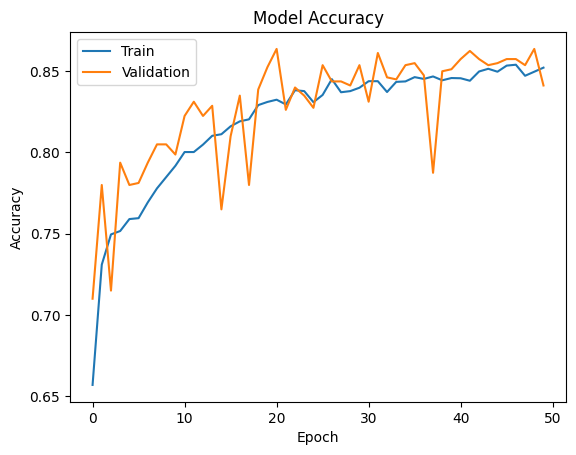

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8253 - loss: 0.4575
Test Loss: 0.4496
Test Accuracy: 0.8250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

      GALAXY       0.90      0.89      0.89      1101
         QSO       0.85      0.69      0.76       447
        STAR       0.66      0.81      0.72       452

    accuracy                           0.82      2000
   macro avg       0.80      0.80      0.79      2000
weighted avg       0.84      0.82      0.83      2000



In [22]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)


# Convert predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_decoded)


print(classification_report(y_test_labels,y_pred_labels))

Assignment 2:



*   Try different choices of number of layers and neurons per layer
*   What is the best **precision** and **recall** values you can obtain?



